In [138]:
import numpy as np
import pandas as pd
from ISLP import load_data
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [139]:
oj = load_data('oj')
oj.head()


,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


In [140]:
x = oj.drop(columns='Purchase')
x = pd.get_dummies(x, columns=['Store7'])  # Encode 'Store7' if it's categorical

y = oj[['Purchase']]
#y_encoded = pd.get_dummies(y, columns=['Purchase'])
X_train, X_test, Y_train, Y_test = train_test_split(x, y, train_size= 800, random_state=42)

## (b) Fit a tree with `Purchase` as the response and other variables as predictors


In [141]:
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt = clf_dt.fit(X_train, Y_train)
y_train_hat = clf_dt.predict(X_train)
training_err = 1 - np.mean(y_train_hat == Y_train.to_numpy())  
print('The training error is:', training_err)

The training error is: 0.4718


## (c) Create a plot of the tree

163

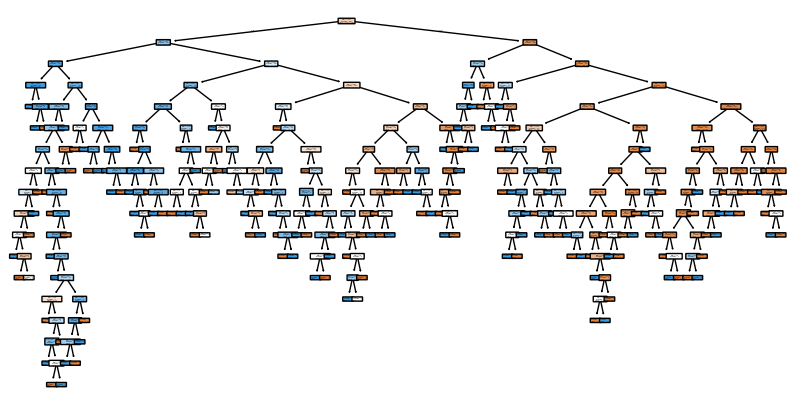

In [142]:
plt.figure(figsize = (10,5))
plot_tree(clf_dt, 
         filled = True, 
         rounded = True, 
         feature_names=X_train.columns);

# how many terminal nodes?
clf_dt.tree_.n_leaves

## (d) text summary of the fitted tree

In [143]:
r = export_text(clf_dt, feature_names=X_train.columns)
print(r)

|--- LoyalCH <= 0.50
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.06
|   |   |   |--- WeekofPurchase <= 268.50
|   |   |   |   |--- class: MM
|   |   |   |--- WeekofPurchase >  268.50
|   |   |   |   |--- SalePriceMM <= 2.15
|   |   |   |   |   |--- class: MM
|   |   |   |   |--- SalePriceMM >  2.15
|   |   |   |   |   |--- class: CH
|   |   |--- LoyalCH >  0.06
|   |   |   |--- LoyalCH <= 0.21
|   |   |   |   |--- WeekofPurchase <= 273.00
|   |   |   |   |   |--- WeekofPurchase <= 261.00
|   |   |   |   |   |   |--- PriceDiff <= -0.13
|   |   |   |   |   |   |   |--- SalePriceMM <= 1.64
|   |   |   |   |   |   |   |   |--- WeekofPurchase <= 236.50
|   |   |   |   |   |   |   |   |   |--- WeekofPurchase <= 234.00
|   |   |   |   |   |   |   |   |   |   |--- LoyalCH <= 0.16
|   |   |   |   |   |   |   |   |   |   |   |--- class: MM
|   |   |   |   |   |   |   |   |   |   |--- LoyalCH >  0.16
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |

Interpretation:

## (e) Predict the response on the test data, produce a confusion matrix , what is the test error rate?

Test error is: 0.48156378600823047


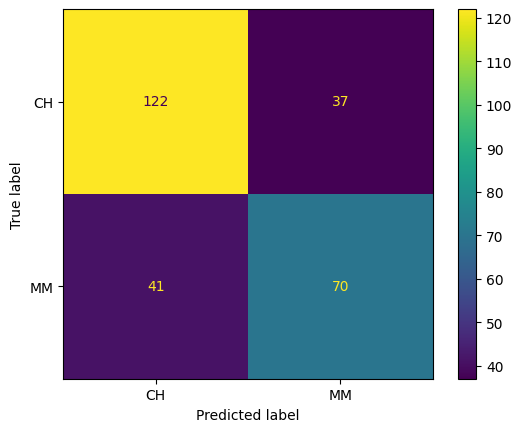

In [144]:
 # let's see how it performs on the Testing Dataset
cm = confusion_matrix(Y_test, clf_dt.predict(X_test))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["CH", "MM"])
disp.plot()

# compute the test error
test_err = 1 - np.mean( (clf_dt.predict(X_test) == Y_test.to_numpy()) )
print('Test error is:', test_err) 

## (f/g/h) Use cross-validation on the training set in order to determine the optimal tree size.

<Axes: xlabel='alpha'>

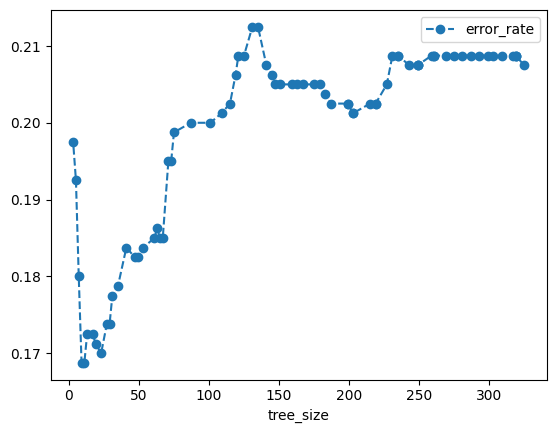

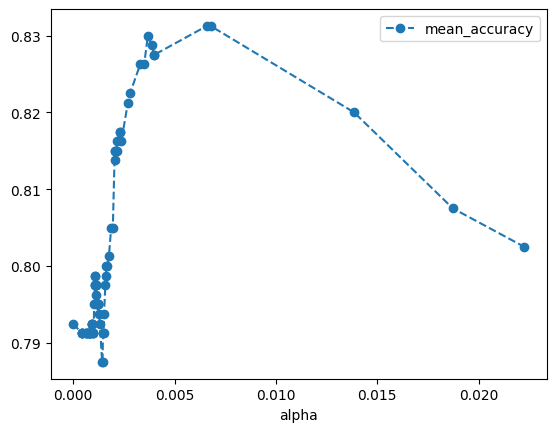

In [145]:
path = clf_dt.cost_complexity_pruning_path(X_train, Y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

alpha_results = []
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, Y_train, cv = 5)
    clf_dt = clf_dt.fit(X_train, Y_train)
    tree_size = clf_dt.tree_.node_count  # Get tree depth after fitting
    alpha_results.append([ccp_alpha, 1 - np.mean(scores), np.mean(scores), tree_size])

alpha_results_df = pd.DataFrame(alpha_results, columns=['alpha','error_rate','mean_accuracy', 'tree_size'])


alpha_results_df.plot(x = 'tree_size',
                  y = 'error_rate', 
                  marker = 'o', 
                  linestyle = '--')
alpha_results_df.plot(x = 'alpha',
                  y = 'mean_accuracy', 
                  marker = 'o', 
                  linestyle = '--')
# find the best 

In [146]:
ideal_ccp_alpha = alpha_results_df.loc[alpha_results_df['mean_accuracy'].idxmax(), 'alpha']

ideal_tree_size = alpha_results_df.loc[alpha_results_df['error_rate'].idxmin(), 'tree_size']
print('The idea tree size is:',ideal_tree_size)

The idea tree size is: 11


In [147]:
# Exploratory: Find the row with the best alpha
ideal_ccp_alpha_row = alpha_results_df.loc[alpha_results_df['alpha'] == ideal_ccp_alpha]

# Extract the tree size for the optimal alpha
ideal_tree_size = ideal_ccp_alpha_row['tree_size'].values[0]
print(f"Ideal Alpha: {ideal_ccp_alpha}, Corresponding Tree Size: {ideal_tree_size}")


Ideal Alpha: 0.006597346201628912, Corresponding Tree Size: 11


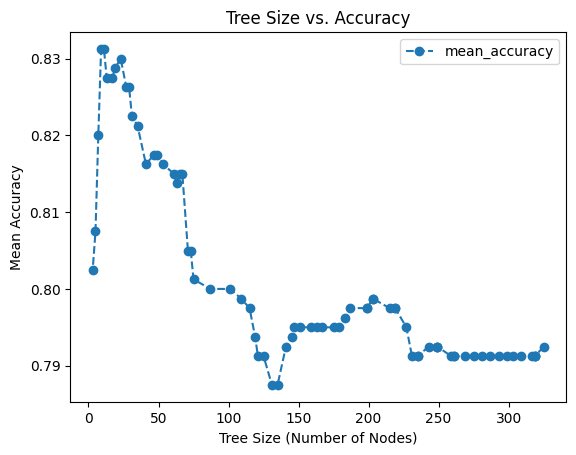

In [148]:
# Exploratory plot : plot tree size vs accuarcy
alpha_results_df.plot(x='tree_size', y='mean_accuracy', marker='o', linestyle='--')
plt.xlabel("Tree Size (Number of Nodes)")
plt.ylabel("Mean Accuracy")
plt.title("Tree Size vs. Accuracy")
plt.show()


## (i) a pruned tree corresponding to the optimal tree size 

In [149]:
clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=ideal_ccp_alpha)
clf_dt = clf_dt.fit(X_train, Y_train)



## (j) Training error rate (comparison between pruned and un-pruned trees)


In [164]:
y_train_hat = clf_dt.predict(X_train)
training_err = 1 - np.mean( (y_train_hat == Y_train.to_numpy()) )
print('training error for the pruned model:', training_err)
print('training error for the un-pruned model is 0.4718')

training error for the pruned model: 0.46093125
training error for the un-pruned model is 0.4718


## (k) Compare the test error between pruned and un-pruned model


In [162]:
y_hat = clf_dt.predict(X_test)
test_err = 1 - np.mean( (y_hat == Y_test.to_numpy()) )
print('test error for the pruned model:', test_err)
print('test error for the un-pruned model is 0.481')

test error for the pruned model: 0.46312757201646093
test error for the un-pruned model is 0.481


In [163]:
test_err_test = 1 - accuracy_score(Y_test, clf_dt.predict(X_test))
test_err_test

0.19259259259259254

In [156]:
y_hat.reshape(-1,1)

array([['CH'],
       ['MM'],
       ['CH'],
       ['CH'],
       ['MM'],
       ['MM'],
       ['MM'],
       ['MM'],
       ['MM'],
       ['CH'],
       ['CH'],
       ['CH'],
       ['MM'],
       ['CH'],
       ['CH'],
       ['CH'],
       ['MM'],
       ['CH'],
       ['MM'],
       ['MM'],
       ['CH'],
       ['CH'],
       ['CH'],
       ['CH'],
       ['CH'],
       ['CH'],
       ['CH'],
       ['CH'],
       ['MM'],
       ['MM'],
       ['MM'],
       ['CH'],
       ['CH'],
       ['CH'],
       ['CH'],
       ['CH'],
       ['CH'],
       ['CH'],
       ['CH'],
       ['CH'],
       ['CH'],
       ['CH'],
       ['MM'],
       ['CH'],
       ['CH'],
       ['CH'],
       ['CH'],
       ['CH'],
       ['CH'],
       ['MM'],
       ['CH'],
       ['CH'],
       ['CH'],
       ['MM'],
       ['CH'],
       ['CH'],
       ['MM'],
       ['CH'],
       ['MM'],
       ['MM'],
       ['MM'],
       ['CH'],
       ['CH'],
       ['CH'],
       ['CH'],
       ['MM'],
       ['M

In [155]:
Y_test.to_numpy

<bound method DataFrame.to_numpy of     Purchase
644       CH
629       MM
70        CH
962       CH
787       CH
..       ...
428       MM
852       CH
605       CH
969       MM
666       MM

[270 rows x 1 columns]>